# Overview

The following data is a collection of medical and demographic data from patients, along with their diabetes status (positive or negative). This dataset includes 100,000 rows and 9 features:

1. gender
2. age
3. hypertension
4. heart_disease
5. smoking_history
6. body mass index (bmi)
7. HbA1c_level
8. blood_glucose_level
9. diabetes

Healthcare professionals may find this data useful in identifying patients at risk of developing diabetes and in developing personalized treatment plans. Furthermore, researchers can explore the relationships between various medical and demographic factors to determine the likelihood of developing diabetes.

## Libraries

In [1]:
# Importing necessary libraries for data manipulation and analysis
import numpy as np
import pandas as pd

# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Importing machine learning-related libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, RocCurveDisplay

# Importing imbalanced learning libraries for dealing with class imbalance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

## Read Data

In [2]:
df = pd.read_csv('/kaggle/input/diabetes2/diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# EDA - Cleaning
1. Understand variables
2. Clean dataset (missing data, redundant data, outliers)

### 1. Gather Information About the Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


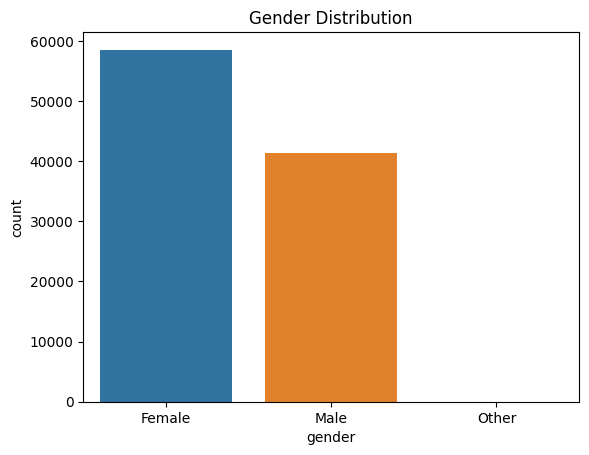

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [4]:
sns.countplot(data = df, x = 'gender')
plt.title('Gender Distribution')
plt.show()

df['gender'].value_counts() # Notice there are 3 unique values for gender

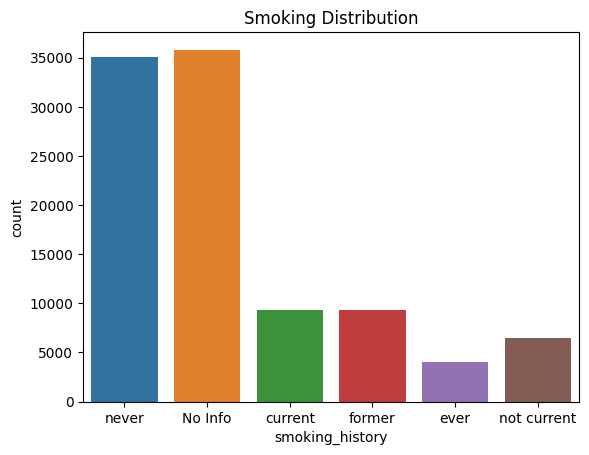

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [5]:
sns.countplot(data = df, x = 'smoking_history')
plt.title('Smoking Distribution')
plt.show()

df['smoking_history'].value_counts() # Notice there are 6 unique values for smoking history

In [6]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


### 2a) Check Missing Variables

In [7]:
print('Percentage of Missing Values')
(df.isna().mean() * 100).round(1) # No missing data!!!

Percentage of Missing Values


gender                 0.0
age                    0.0
hypertension           0.0
heart_disease          0.0
smoking_history        0.0
bmi                    0.0
HbA1c_level            0.0
blood_glucose_level    0.0
diabetes               0.0
dtype: float64

### 2b) Check for Duplicate Entries, Unnecessary Columns, and Data Formatting

In [8]:
print('Amount of duplicates: {:,}'.format(df.duplicated().sum()))

Amount of duplicates: 3,854


In [9]:
df.drop_duplicates(inplace = True)

print('Amount of duplicates: {:,}'.format(df.duplicated().sum()))

Amount of duplicates: 0


In [10]:
df.columns # All columns seem useful in our analysis
df.rename(columns = {'HbA1c_level': 'HbA1c', 'blood_glucose_level': 'blood_glu'}, inplace = True)

In [11]:
# For our analysis, we will be removing Other values in 'gender' to simplify prediction
df = df[~(df['gender'] == 'Other')]

### 2c) Check Outliers

In [12]:
def detect_outliers(df, column_names):
    """
    Detect outliers in the specified columns of a DataFrame and visualize the results.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - column_names (list): A list of column names to analyze for outliers.

    Returns:
    - pd.DataFrame: A DataFrame containing information about outliers for each specified column.
      Columns: ['Column', 'Number of Outliers', '% Outliers', 'Lower Limit', 'Upper Limit']
    """

    # Calculate the number of columns and rows for subplots
    col_len = len(column_names)
    num_columns = 2 if (col_len % 2 == 0) else min(col_len, 3)
    num_rows = (col_len + num_columns - 1) // num_columns  # Calculate the number of rows

    # Create subplots
    fig, axes = plt.subplots(num_rows * 2, num_columns, figsize = (7 * num_columns, 5 * num_rows), squeeze = False)

    # Initialize a list to store outlier information for each column
    outlier_data = []

    # Iterate over column_names and create subplots
    for i, column_name in enumerate(column_names):
        data = df[column_name]

        # Calculate quartiles and interquartile range using np.percentile
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1

        # Define lower and upper limits for outlier detection
        low_lim, upp_lim = q1 - 1.5 * iqr, q3 + 1.5 * iqr

        # Find and display outliers
        outliers = df[(data < low_lim) | (data > upp_lim)][column_name]
        num_outliers = len(outliers)
        percent_outliers = round(num_outliers / len(df) * 100, 1)

        # Append outlier information to the list
        outlier_data.append([column_name, num_outliers, percent_outliers, round(low_lim, 1), round(upp_lim, 1)])

        # Calculate row and column indices for plotting
        row_index, col_index = divmod(i, num_columns)

        # Create a boxplot to visualize the distribution and detect outliers
        ax_box, ax_hist = axes[row_index * 2, col_index], axes[row_index * 2 + 1, col_index]
        sns.boxplot(x = data, ax = ax_box)
        ax_box.set(title = column_name.capitalize(), xlabel = None)
        ax_box.axvline(low_lim, color = 'red', linestyle = '--', label = f'Lower Limit: {low_lim:.1f}')
        ax_box.axvline(upp_lim, color = 'red', linestyle = '--', label = f'Upper Limit: {upp_lim:.1f}')
        ax_box.legend()

        # Create a histogram below the boxplot
        sns.histplot(data, bins = 20, ax = ax_hist, color = '#FF8C00')
        ax_hist.set(xlabel = None)
        ax_hist.set_yscale('log')  # Set y-axis scale to logarithmic
        ax_hist.set_ylabel(None)  # Disable y-axis label

    # Display the subplots
    plt.tight_layout()
    plt.show()

    # Combine the outlier information into a DataFrame
    outlier_df = pd.DataFrame(outlier_data,
                              columns = ['Column', 'Number of Outliers', '% Outliers', 'Lower Limit', 'Upper Limit'])
    return outlier_df

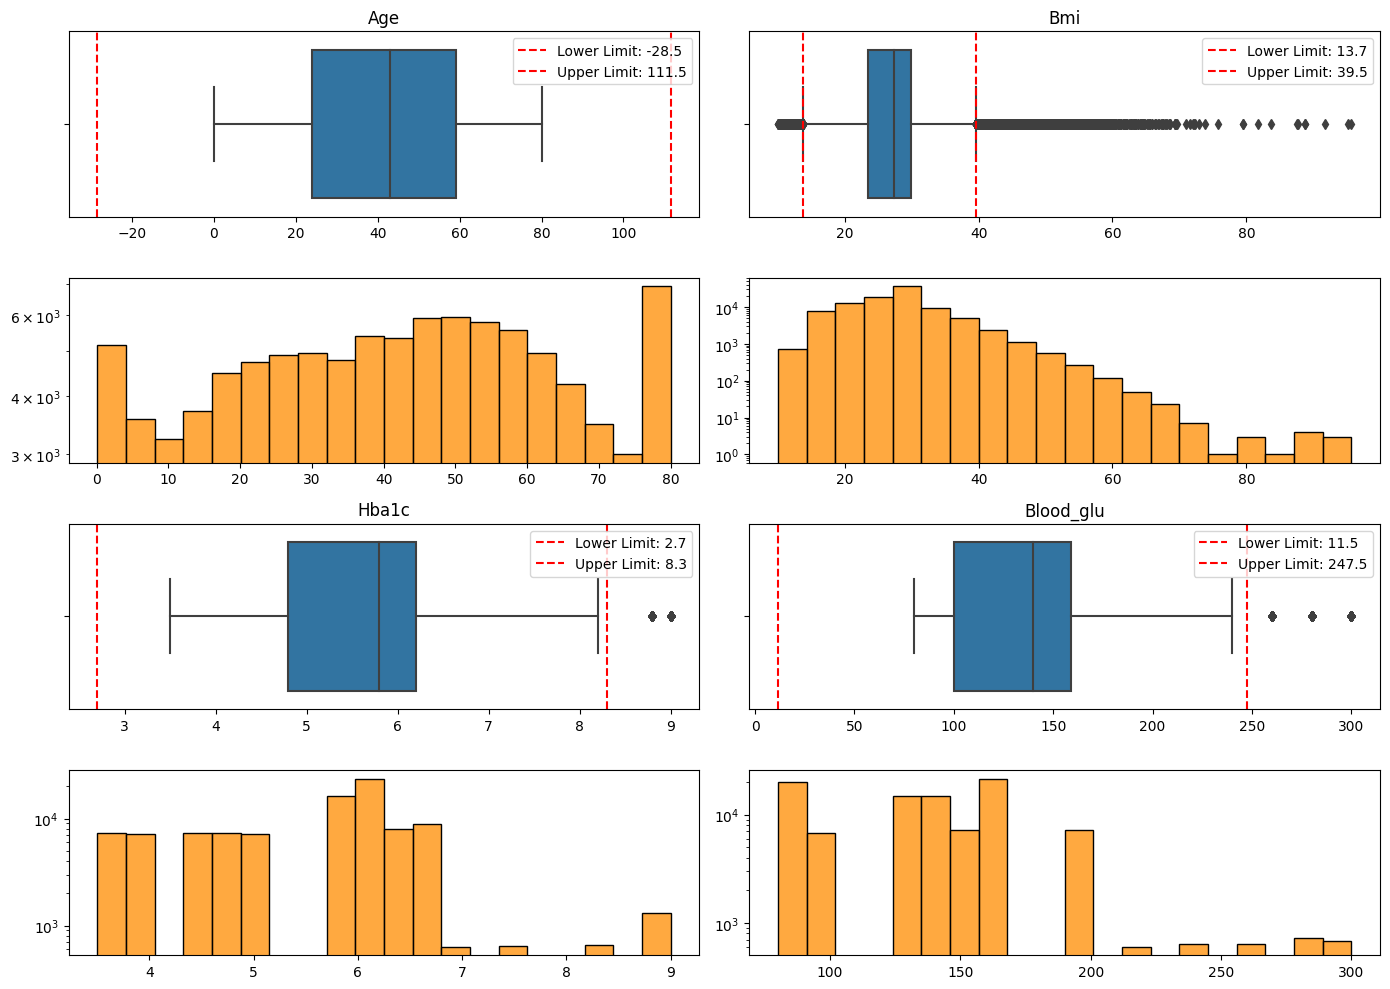

,Column,Number of Outliers,% Outliers,Lower Limit,Upper Limit
0,age,0,0.0,-28.5,111.5
1,bmi,5354,5.6,13.7,39.6
2,HbA1c,1312,1.4,2.7,8.3
3,blood_glu,2031,2.1,11.5,247.5


In [13]:
# Selecting only numerical columns that are not binary values
outlier_col = ['age', 'bmi', 'HbA1c', 'blood_glu']
detect_outliers(df, outlier_col)

**Since the outliers are < 6% of the data and these metrics (BMI, HbA1c, and blood glucose level) are strong indicators of diabetes, I'll retain these values for our analysis.**

# EDA - Visualizations

In [14]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c,blood_glu,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [15]:
# Group by gender and calculate the sum of diabetes cases for each gender
amount_diabetes_per_gender = df.groupby('gender')['diabetes'].sum().reset_index()

# Create a bar plot using Plotly Express
fig_gender = px.bar(
    df,
    x = ['Female', 'Male'],
    y = amount_diabetes_per_gender['diabetes'].values,
    title = 'Diabetes Prevalence Amongst Sexes',
    color = ['Female', 'Male'],
    text = amount_diabetes_per_gender['diabetes'].values,
)

# Update the layout of the plot
fig_gender.update_layout(
    title = {'font': {'size': 23}, 'x': 0.5},
    yaxis = {'title': 'Individuals with Diabetes', 'titlefont': {'size': 16}, 'tickformat': ','},
    xaxis = {'title': 'Sex', 'titlefont': {'size': 16}, 'tickfont': {'size': 16}},
    showlegend = False
)

# Update traces for inside text
fig_gender.update_traces(
    insidetextanchor = 'middle',
    insidetextfont = {'color': 'white', 'size': 13},
    texttemplate = '%{text:,.0f}',
)

# Display the plot
fig_gender.show()

In [16]:
# Calculate the percentage of diabetes occurrences
diabetes_perc = (df['diabetes'].value_counts() / len(df['diabetes'])).apply('{:.1%}'.format).values

# Create the bar chart
fig_diabetes = px.bar(
    df,
    x = ['Normal', 'Diabetic'],
    y = [df['diabetes'].value_counts().values],
    title = 'Percentage of Diabetic Individuals',
    text = diabetes_perc,
    labels = {'value': 'Number of Individuals'},
    color = ['Normal', 'Diabetic']
)

# Include text in bar
fig_diabetes.update_traces(
    insidetextanchor = 'middle', 
    insidetextfont = {'color': 'white', 'size': 13}
)

# Update layout properties
fig_diabetes.update_layout(
    title = {'font': {'size': 23}, 'x': 0.5},
    xaxis = {'title': 'Condition', 'tickfont': {'size': 16}, 'titlefont': {'size': 16}},
    yaxis = {'titlefont': {'size': 16}},
    showlegend = False,
)

# Show the plot
fig_diabetes.show()

In [17]:
# Define conditions based on gender and diabetes status
conditions = [
    (df['gender'] == 'Male') & (df['diabetes'] == 0),
    (df['gender'] == 'Male') & (df['diabetes'] == 1),
    (df['gender'] == 'Female') & (df['diabetes'] == 0),
    (df['gender'] == 'Female') & (df['diabetes'] == 1)
]

# Define corresponding choices for each condition
choices = [
    'Male | Normal',
    'Male | Diabetic',
    'Female | Normal',
    'Female | Diabetic'
]

# Apply conditions and choices to create the 'category' column
df['category'] = np.select(conditions, choices, default = 'Unknown')

fig_age_bmi = px.scatter(
    df,
    x = 'age', 
    y = 'bmi',
    title = 'Age vs BMI by Sex and Diabetic Status',
    labels = {'bmi': 'BMI', 'age': 'Age'},
    color = 'category',
    color_discrete_map = {
        'Male | Normal': 'blue', 
        'Male | Diabetic': 'orange',
        'Female | Normal': 'lightgreen', 
        'Female | Diabetic': 'darkred'
    }
)

fig_age_bmi.update_layout(
    title = {'x': 0.5}, 
    legend_title = ''
)

fig_age_bmi.show()

In [18]:
smoking_perc = df.groupby(['smoking_history', 'diabetes'], as_index = False)['diabetes'].count()

smoking_labels = [
    'Current | Normal',
    'Current | Diabetic',
    'Ever | Normal',
    'Ever | Diabetic',
    'Former | Normal',
    'Former | Diabetic',
    'Never | Normal',
    'Never | Diabetic',
    'No Info | Normal',
    'No Info | Diabetic',
    'Not Current | Normal',
    'Not Current | Diabetic',
]

fig_smoking = px.bar(
    df,
    x = smoking_perc['smoking_history'],
    y = smoking_perc['diabetes'].values,
    barmode = 'group',
    title = 'Smoking History and Diabetes',
    color = smoking_labels,
)

fig_smoking.update_traces(
    insidetextanchor = 'middle', 
    insidetextfont = {'color': 'white', 'size': 13}
)

fig_smoking.update_layout(
    title_x = 0.5,
    xaxis = {'title': 'Smoking History'},
    yaxis = {'title': 'Number of Individuals'},
    legend = {'title': ''}
)

fig_smoking.show()

In [19]:
fig_bmi = px.box(
    df,
    x = 'diabetes',
    y = 'bmi',
    title = 'Diabetes, BMI, & Sex',
    labels = {'diabetes': 'Condition', 'bmi': 'BMI'},
    color = 'gender'
)

fig_bmi.update_layout(title_x = 0.5, legend_title = '')

fig_bmi.update_xaxes(tickvals = [0, 1], ticktext = ['Normal', 'Diabetic'])

fig_bmi.show()

In [20]:
fig_blood_glu = px.box(
    df,
    x = 'diabetes',
    y = 'blood_glu',
    title = 'Blood Glucose by Diabetes and Sex',
    labels = {'diabetes': 'Condition', 'blood_glu': 'Blood Glucose Level'},
    color = 'gender'
)

fig_blood_glu.update_layout(title_x = 0.5, legend_title = '')

fig_blood_glu.update_xaxes(tickvals = [0, 1], ticktext = ['Normal', 'Diabetic'])

fig_blood_glu.show()

In [21]:
hyperten_count = df.groupby(['hypertension', 'gender'], as_index = False)['diabetes'].count()

fig_hyperten = px.bar(
    hyperten_count,
    x = hyperten_count['hypertension'].values,
    y = hyperten_count['diabetes'].values,
    title = 'Hypertension as Seen in Diabetes',
    barmode = 'group',
    color = 'gender',
    labels = {'x': 'Condition', 'y': 'Number of Individuals'}
)

fig_hyperten.update_layout(title_x = 0.5, legend_title = '')

fig_hyperten.update_xaxes(tickvals = [0, 1], ticktext = ['Normal', 'Diabetic'])

fig_hyperten.show()

# Data Preprocessing

In [22]:
# Encode categorical variables using Label Encoding
label_encoder = LabelEncoder()

df['gender'] = label_encoder.fit_transform(df['gender'])
df['smoking_history'] = label_encoder.fit_transform(df['smoking_history'])

## Balancing Dataset (91.2% Normal vs 8.8% Diabetic)

In [23]:
# Separate features (X) and target variable (y)
X = df.drop(columns = ['diabetes', 'category']).values
y = df['diabetes'].values

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Combine the features and target variable for the training set
train_data = pd.concat(
    [pd.DataFrame(X_train, columns = df.drop(columns = ['diabetes', 'category']).columns), 
    pd.Series(y_train, name = 'target')], 
    axis = 1
)

# Separate majority and minority classes
majority_class = train_data[train_data['target'] == 0]
minority_class = train_data[train_data['target'] == 1]

# Upsample the minority class
minority_upsampled = resample(minority_class, replace = True, n_samples = len(majority_class), random_state = 42)

# Combine majority class with upsampled minority class
balanced_data = pd.concat([majority_class, minority_upsampled])

# Separate features and target variable for the balanced dataset
X_balanced = balanced_data.drop('target', axis = 1)
y_balanced = balanced_data['target']

# **Gradient Boost**

In [24]:
# Train a Gradient Boosting Classifier on the balanced training data
model = GradientBoostingClassifier(random_state = 42)
model.fit(X_balanced, y_balanced)

# Make predictions on the test set
y_pred_gb = model.predict(X_test)

# Evaluate the model and display the classification report
class_report_gradient_boost = classification_report(y_test, y_pred_gb, target_names = ['Non-Diabetic', 'Diabetic'])

print('Classification Report:\n', class_report_gradient_boost)

Classification Report:
               precision    recall  f1-score   support

Non-Diabetic       0.99      0.90      0.94     17525
    Diabetic       0.48      0.92      0.63      1701

    accuracy                           0.90     19226
   macro avg       0.73      0.91      0.79     19226
weighted avg       0.95      0.90      0.92     19226



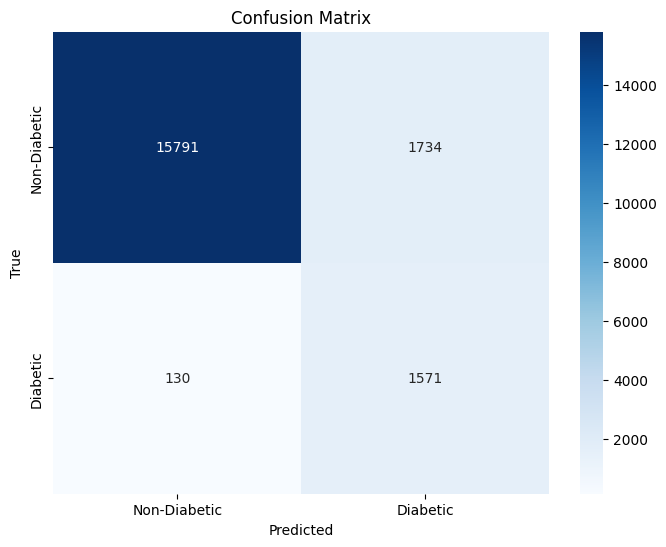

In [25]:
# Plot confusion matrix as a heatmap
plt.figure(figsize = (8, 6))

conf_matrix = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(
    conf_matrix, 
    annot = True, 
    fmt = 'd', 
    cmap = 'Blues', 
    xticklabels = ['Non-Diabetic', 'Diabetic'], 
    yticklabels = ['Non-Diabetic', 'Diabetic']
)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

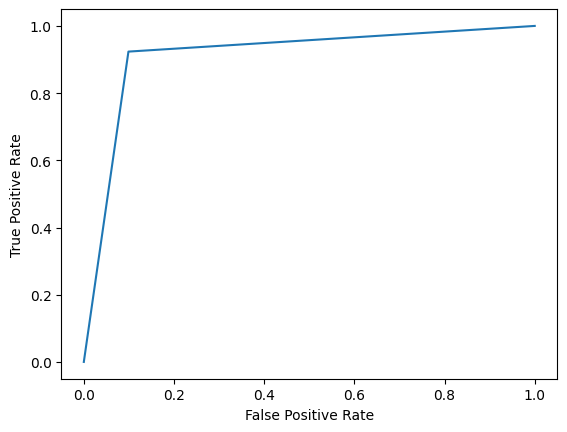

In [26]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_gb)
roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr)
roc_display.plot()

plt.show()

# **Random Forest**

In [27]:
rand_forest = RandomForestClassifier(random_state = 42)
rand_forest.fit(X_balanced, y_balanced)

# Make predictions on the test set
y_pred_rf = rand_forest.predict(X_test)

# Evaluate the model and display the classification report
class_report_rand_forest = classification_report(y_test, y_pred_rf, target_names = ['Non-Diabetic', 'Diabetic'])

print('Classification Report:\n', class_report_rand_forest)

Classification Report:
               precision    recall  f1-score   support

Non-Diabetic       0.97      0.99      0.98     17525
    Diabetic       0.85      0.70      0.77      1701

    accuracy                           0.96     19226
   macro avg       0.91      0.84      0.87     19226
weighted avg       0.96      0.96      0.96     19226



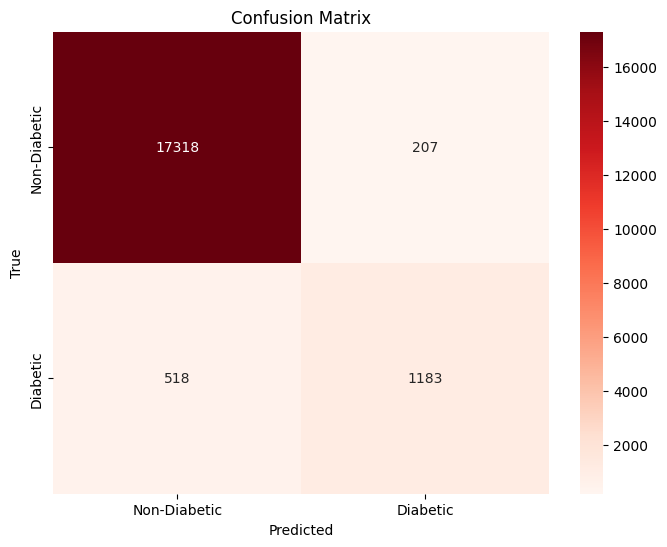

In [28]:
# Plot confusion matrix as a heatmap
plt.figure(figsize = (8, 6))

conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(
    conf_matrix, 
    annot = True, 
    fmt = 'd', 
    cmap = 'Reds', 
    xticklabels = ['Non-Diabetic', 'Diabetic'], 
    yticklabels = ['Non-Diabetic', 'Diabetic']
)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

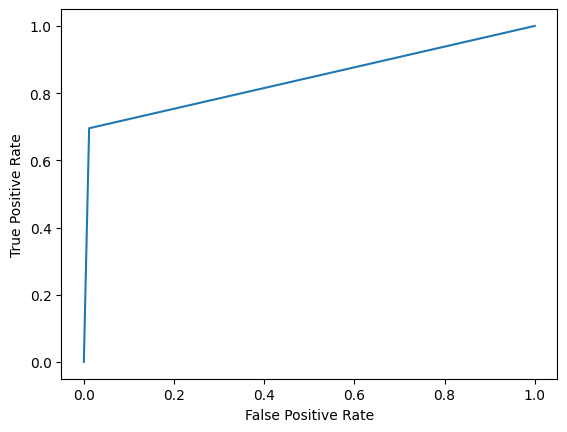

In [29]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr)
roc_display.plot()

plt.show()